In [1]:
%matplotlib inline
import json, sqlite3, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from collections import Counter
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from datetime import date 
from datetime import datetime
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import difflib
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score

In [35]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

rc('font', **font)

### Load data

In [2]:
DATA_PICKLE_FILE = '2009-2016-wk5-extra-features.pickle'

In [3]:
try:
    df = pd.read_pickle(DATA_PICKLE_FILE)
    print 'File read'
except:
    print 'File does not exist' 

File does not exist


In [4]:
# Load database
DATABASE = "Week5.db"
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

### Data overview

In [5]:
# Total players
pd.read_sql_query('SELECT name, COUNT (*) FROM Injuries GROUP BY name', conn).shape[0]

4966

In [6]:
# Total features
pd.read_sql_query('PRAGMA table_info(Injuries)', conn).shape[0]

90

In [7]:
# DNP vs not DNP
df = pd.read_sql_query("""SELECT dnp, COUNT (*) FROM Injuries 
            WHERE injury_type != "none" AND injury_type NOT LIKE '%suspension%' 
            AND height NOT NULL AND weight NOT NULL AND age NOT NULL 
            AND season IN ("2009", "2010", "2011", "2012", "2013", "2014", "2015")
            GROUP BY dnp"""
                        , conn)
print df[df['dnp']=='0']['COUNT (*)'][0]/df[df['dnp']!='0']['COUNT (*)']

1    0.615183
Name: COUNT (*), dtype: float64


In [8]:
# Types of injuries
pd.read_sql_query('SELECT  injury_type, COUNT (*)  FROM Injuries GROUP BY injury_type', conn).sort_values(['COUNT (*)'], ascending = False)     

,injury_type,COUNT (*)
368,none,167542
283,knee,14342
12,ankle,6578
462,shoulder,4548
200,hamstring,4434
137,feet,3399
93,concussion,2062
43,back,2032
179,groin,1828
6,achilles,1580


In [9]:
# Types of status
pd.read_sql_query('SELECT  status, COUNT (*)  FROM Injuries GROUP BY status', conn)

,status,COUNT (*)
0,D,1209
1,IR,23328
2,None,167542
3,O,4262
4,P,12882
5,PUP,1312
6,Q,17591
7,S,176


In [11]:
#Types of statuses
pd.read_sql_query("""SELECT  status, dnp, COUNT (*)  
                     FROM Injuries 
                     GROUP BY status, dnp""", conn).sort_values(['dnp', 'COUNT (*)'])

,status,dnp,COUNT (*)
11,S,0,4
0,D,0,161
2,IR,0,199
9,Q,0,10500
6,P,0,11857
4,None,0,167542
12,S,1,172
7,P,1,1025
1,D,1,1048
8,PUP,1,1312


In [12]:
# Print percent of players that played, per label
played = pd.read_sql_query('SELECT  status, COUNT (*) FROM Injuries WHERE dnp = 0 AND season != "2016" GROUP BY status  ', conn)
played_dict = dict([tuple(value) for value in played.values])

not_played = pd.read_sql_query('SELECT  status, COUNT (*) FROM Injuries WHERE dnp = 1 AND season != "2016" GROUP BY status ', conn)
not_played_dict = dict([tuple(value) for value in not_played.values])

dnp_per = {}
for k in set(played_dict.keys() + not_played_dict.keys()):
    dnp_val = not_played_dict.get(k, 0)
    total = dnp_val + played_dict.get(k, 0)
    dnp_per[k] = (1-dnp_val/float(total))*100
print dnp_per

{u'None': 100.0, u'D': 14.110429447852757, u'IR': 0.8934985632183867, u'O': 0.0, u'Q': 59.443699341069454, u'P': 92.04316099984474, u'S': 2.2727272727272707, u'PUP': 0.0}


### Figure: Actual vs predicted probabilities of playing given coach's label

/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


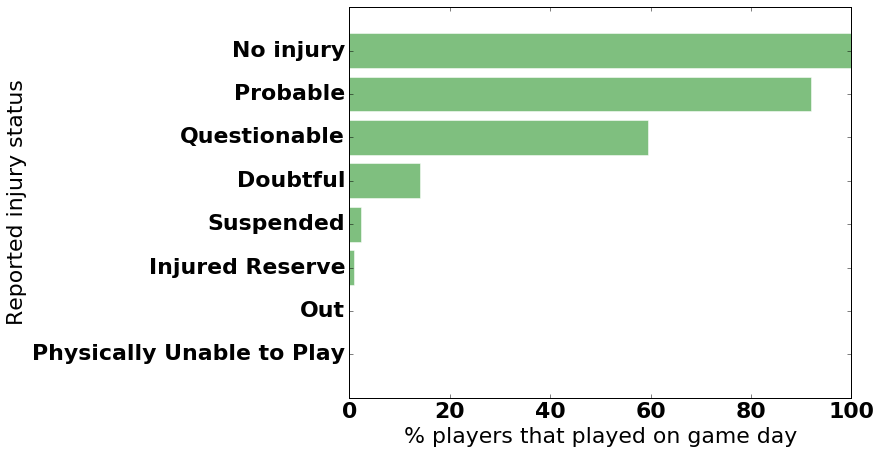

In [14]:
x_pos = np.arange(len(dnp_per.items()))
x, y = zip(*sorted([(k, v) for k, v in dnp_per.items()], key = lambda x: x[1], reverse = True))
Status = {'None': 0, 'P': 0.25, 'Q': 0.5, 'S': 1, 'D': 0.75, 'IR': 1, 'O': 1, 'PUP': 1}

_, y_reported = zip(*(sorted([(k, v) for k, v in Status.items()], key = lambda x: x[1])))
fig, ax = plt.subplots(figsize=(9, 7))
plt.xlabel("% players that played on game day")
plt.ylabel("Reported injury status")
tick_label=('No injury', 'Probable', 'Questionable', 'Doubtful', 'Suspended', 'Injured Reserve', 'Out', 'Physically Unable to Play')
ax.barh(x_pos, y, color="g", alpha = 0.5, edgecolor = 'white', align = 'center')

ax.set_yticklabels(tick_label)
plt.gca().invert_yaxis()
plt.yticks(x_pos, tick_label, rotation = 'horizontal')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

rc('font', **font)
plt.show()

In [15]:
# Injury type vs avg weeks, by position 
ans = pd.read_sql_query('SELECT injury_type, position, COUNT (*) FROM Injuries WHERE dnp = 1 GROUP BY injury_type, position', conn) 
print ans.sort_values(['injury_type','COUNT (*)',  'position'], ascending = [False, False, True])

                    injury_type position  COUNT (*)
1052                 wrist hips       WR          1
1051           wrist concussion       WR          1
1050                wrist ankle       WR          2
1040                      wrist       LB        139
1049                      wrist       WR         90
1034                      wrist       CB         38
1035                      wrist       DB         38
1048                      wrist       TE         25
1036                      wrist       DE         21
1037                      wrist       DT         20
1038                      wrist       FB         16
1044                      wrist       RB         16
1045                      wrist        S         16
1039                      wrist        G         15
1047                      wrist        T         10
1042                      wrist      OLB          9
1033                      wrist        C          6
1041                      wrist       LS          1
1043        

### Figure: Frequency analysis of injury types

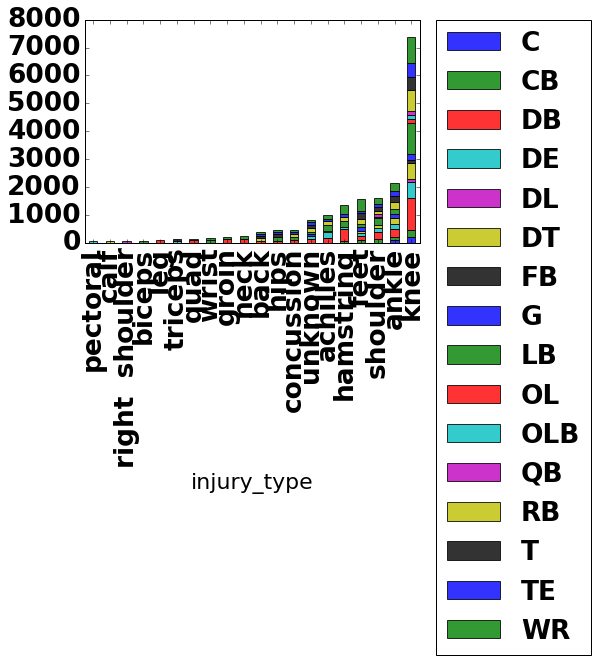

[{u'OLB': 59, u'TE': 84, u'LB': 250, u'CB': 127, u'DE': 140, u'DB': 276, u'QB': 84, u'WR': 240, u'RB': 124, 'total': 1617, u'DT': 90, 'injury_type': u'shoulder', u'T': 143}, {u'TE': 117, u'LB': 214, u'CB': 81, u'DE': 83, u'DB': 412, u'WR': 322, u'RB': 145, 'total': 1374, 'injury_type': u'hamstring'}, {'total': 78, 'injury_type': u'biceps', u'LB': 78}, {'total': 60, 'injury_type': u'pectoral', u'DE': 60}, {'total': 236, u'DB': 132, 'injury_type': u'neck', u'LB': 104}, {'total': 86, 'injury_type': u'leg', u'DB': 86}, {u'TE': 102, u'LB': 79, u'G': 76, u'DE': 101, u'DB': 149, u'WR': 98, u'RB': 141, 'total': 836, 'injury_type': u'unknown', u'T': 90}, {u'TE': 78, u'LB': 111, u'WR': 63, u'RB': 102, 'total': 466, 'injury_type': u'concussion', u'DB': 112}, {'total': 139, 'injury_type': u'triceps', u'DE': 66, u'T': 73}, {u'TE': 60, u'T': 95, 'total': 373, u'DT': 89, 'injury_type': u'back', u'DB': 71, u'WR': 58}, {'total': 151, u'DB': 91, 'injury_type': u'quad', u'DE': 60}, {'total': 77, 'injury_

In [17]:
# Frequency analysis of injury_types, 2009 - 2015
results_dict = {}
for injury_type, position, count in results:
    if injury_type in results_dict:
        results_dict[injury_type].update({position: count})
    else:
        results_dict[injury_type] = {position: count}
items = []
for k, v in results_dict.iteritems():
    item = {'injury_type': k}
    item.update(v)
    item['total'] = sum(v.values())
    items.append(item)
plt.figure(figsize = (30,15))
to_plot = pd.DataFrame(items).sort_values('total').set_index('injury_type').drop('total', 1)
to_plot.plot.bar(stacked=True, alpha = 0.8, edgecolor = 'None', fontsize = 'large')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print items

### Figure: Most concussions

In [20]:
# find number of teams that played each week
Teams_playing = pd.read_sql_query("""
                SELECT a.season, a.week_num, COUNT (*) as teams_playing FROM
                (SELECT DISTINCT season, week_num, team FROM Injuries 
                WHERE week_num NOT NULL) a
                GROUP BY a.week_num, a.season
                                """, conn)

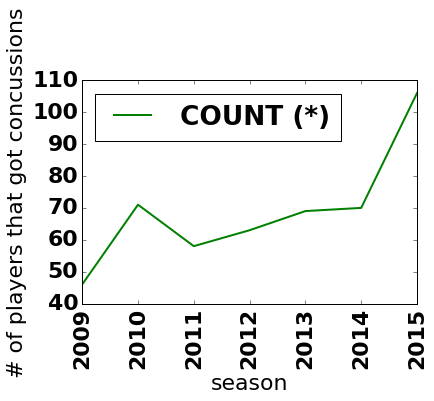

In [21]:
# Concussions - Where they also don't play
injury_type = 'concussion'
pd.read_sql_query("""
                SELECT a.season, COUNT (*) FROM
                (SELECT DISTINCT name, season
                FROM Injuries
                WHERE injury_type LIKE '%{}%' AND season != '2016' 
                AND dnp == 1 AND injury_type_pre_consec_season IS NULL 
                AND week_num <= 22)a 
                GROUP BY a.season""".format(injury_type), conn).sort_values(['season']).plot(x='season', y = 'COUNT (*)', lw = '2', color='g')

plt.ylabel('# of players that got concussions', rotation = 'vertical')
plt.xticks( rotation = 'vertical', fontsize = 'medium')
plt.show()

/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


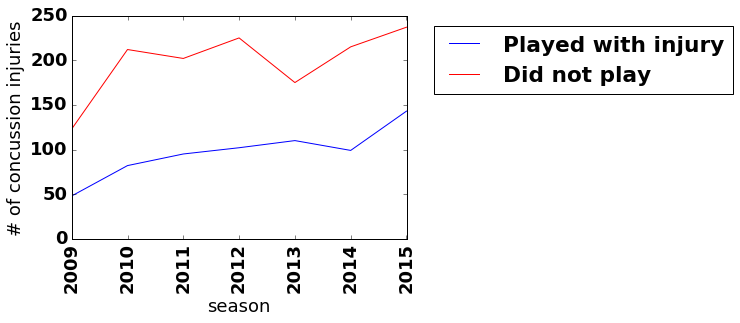

In [54]:
# Concussions - Total #, played and didn't
injury_type = 'concussion'
player = 'QB'
df = pd.read_sql_query("""
                SELECT a.season AS season, a.dnp AS dnp, COUNT (*) AS count FROM
                (SELECT  name, season, dnp
                FROM Injuries
                WHERE injury_type LIKE '%{}%' AND season != '2016'
                AND week_num <= 22)a 
                GROUP BY a.season, a.dnp """.format(injury_type, player), conn).sort_values(['season'])

df['color'] = 'blue'
df['color'][df['dnp']=='1'] = 'red'

color_key = {'blue': 'Played with injury', 'red': 'Did not play'}

fig, ax = plt.subplots()
labels = []
for key, grp in df.groupby(['color']):
    ax = grp.plot(ax=ax, kind='line', x='season', y='count', c=key, label = color_key[key])
    labels.append(color_key[key])
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel('# of {} injuries'.format(injury_type), rotation = 'vertical')
plt.xticks( rotation = 'vertical', fontsize = 'medium')
plt.show()

/Users/Grace/.virtualenvs/my_projects_env/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


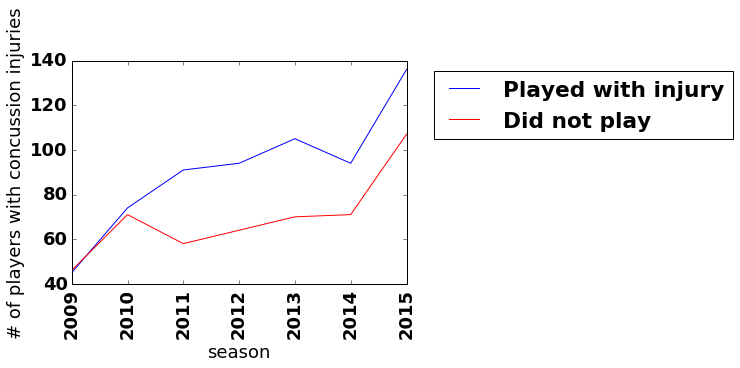

In [55]:
# Concussions - Total people that got concussions
injury_type = 'concussion'
df = pd.read_sql_query("""
                SELECT a.season AS season, a.dnp AS dnp, COUNT (*) AS count FROM
                (SELECT DISTINCT name, team, season, dnp
                FROM Injuries
                WHERE injury_type LIKE '%{}%' AND season != '2016' 
                AND week_num <= 22)a 
                GROUP BY a.season, a.dnp """.format(injury_type), conn).sort_values(['season'])

df['color'] = 'blue'
df['color'][df['dnp']=='1'] = 'red'

color_key = {'blue': 'Played with injury', 'red': 'Did not play'}

fig, ax = plt.subplots()
labels = []
for key, grp in df.groupby(['color']):
    ax = grp.plot(ax=ax, kind='line', x='season', y='count', c=key, label = color_key[key])
    labels.append(color_key[key])
lines, _ = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.ylabel('# of players with {} injuries'.format(injury_type), rotation = 'vertical')
plt.xticks( rotation = 'vertical', fontsize = 'medium')
plt.show()

### Most severe injuries

In [24]:
# All most severe injuries
position = 'QB'
Most_severe_by_pos = pd.read_sql_query("""
                SELECT injury_type, injury_type_tot_consec_season, COUNT (*) 
                FROM Injuries WHERE position == 'QB' AND dnp == 1 AND injury_type NOT NULL     
                AND injury_type_pre_consec_season IS NULL AND season != '2016'
                GROUP BY injury_type, injury_type_tot_consec_season""".format(injury_type)
                  , conn).sort_values(['COUNT (*)', 'injury_type_tot_consec_season', ], ascending = False)
Most_severe_by_pos['COUNT (*)'].sum()
Most_severe_by_pos.set_index('injury_type')

,injury_type_tot_consec_season,COUNT (*)
injury_type,,
concussion,2.0,19
illness,1.0,16
knee,2.0,13
knee,3.0,9
ankle,1.0,9
concussion,1.0,9
knee,1.0,7
right shoulder,2.0,6
ankle,2.0,5


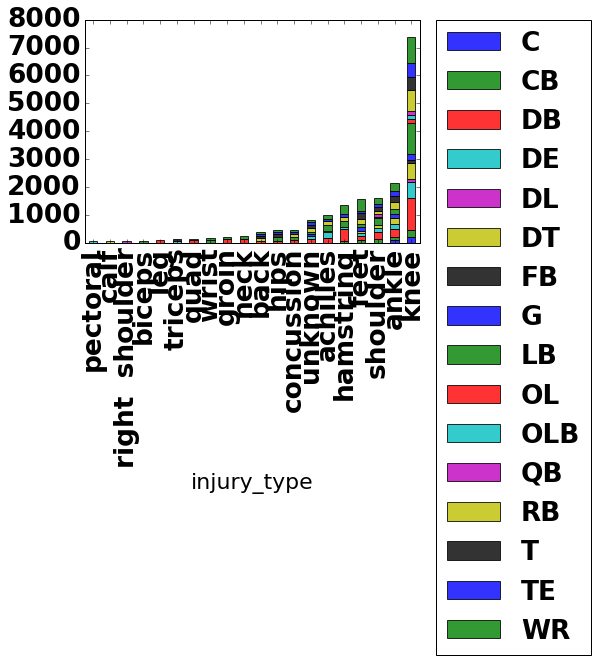

[{u'OLB': 59, u'TE': 84, u'LB': 250, u'CB': 127, u'DE': 140, u'DB': 276, u'QB': 84, u'WR': 240, u'RB': 124, 'total': 1617, u'DT': 90, 'injury_type': u'shoulder', u'T': 143}, {u'TE': 117, u'LB': 214, u'CB': 81, u'DE': 83, u'DB': 412, u'WR': 322, u'RB': 145, 'total': 1374, 'injury_type': u'hamstring'}, {'total': 78, 'injury_type': u'biceps', u'LB': 78}, {'total': 60, 'injury_type': u'pectoral', u'DE': 60}, {'total': 236, u'DB': 132, 'injury_type': u'neck', u'LB': 104}, {'total': 86, 'injury_type': u'leg', u'DB': 86}, {u'TE': 102, u'LB': 79, u'G': 76, u'DE': 101, u'DB': 149, u'WR': 98, u'RB': 141, 'total': 836, 'injury_type': u'unknown', u'T': 90}, {u'TE': 78, u'LB': 111, u'WR': 63, u'RB': 102, 'total': 466, 'injury_type': u'concussion', u'DB': 112}, {'total': 139, 'injury_type': u'triceps', u'DE': 66, u'T': 73}, {u'TE': 60, u'T': 95, 'total': 373, u'DT': 89, 'injury_type': u'back', u'DB': 71, u'WR': 58}, {'total': 151, u'DB': 91, 'injury_type': u'quad', u'DE': 60}, {'total': 77, 'injury_

In [25]:
# Frequency analysis of injury_types, 2009 - 2015
results_dict = {}
for injury_type, position, count in results:
    if injury_type in results_dict:
        results_dict[injury_type].update({position: count})
    else:
        results_dict[injury_type] = {position: count}
items = []
for k, v in results_dict.iteritems():
    item = {'injury_type': k}
    item.update(v)
    item['total'] = sum(v.values())
    items.append(item)
plt.figure(figsize = (30,15))
to_plot = pd.DataFrame(items).sort_values('total').set_index('injury_type').drop('total', 1)
to_plot.plot.bar(stacked=True, alpha = 0.8, edgecolor = 'None', fontsize = 'large')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print items

### Historical trends

In [26]:
conn = sqlite3.connect(DATABASE)
cur = conn.cursor()

In [27]:
# Injuries by time in the defense line
position = 'WR'
injury_type = 'head'
DF = pd.read_sql_query("""
                SELECT a.season, COUNT (*) FROM
                (SELECT name, season, COUNT (*)
                FROM Injuries
                WHERE injury_type LIKE '%{}%' AND 
                week_num <= 17 AND position IN ('DB', 'DT', 'DE', 'DL', 'LB', 'ILB', 'OLB', 'S', 'FS', 'SS', 'QB', 'K', 'P') 
                 GROUP BY name, season)a 
                GROUP BY a.season""".format(injury_type)
                  , conn).sort_values(['season','COUNT (*)' ], ascending = False)


### Number of games missed per season given an injury

In [29]:
injury_type = 'rib'
position = 'RB'
DF = pd.read_sql_query("""SELECT name, season, injury_type, position, dnp, COUNT (*) 
                    FROM Injuries 
                    WHERE injury_type == '{}' AND position == '{}' AND dnp == 1 
                    GROUP BY name, season, injury_type, position, dnp""".format(injury_type, position), conn)

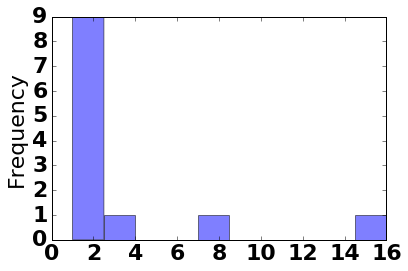

In [30]:
DF['COUNT (*)'].plot.hist(alpha = 0.5)
plt.show()

### Injuries over a season

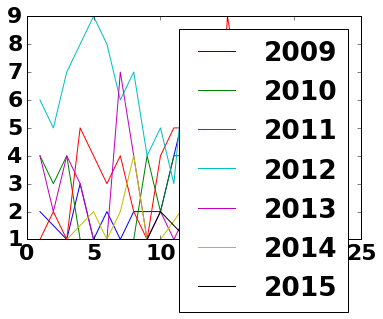

In [22]:
injury_type = 'head'

plt.figure()
Injuries_over_season = pd.DataFrame()
for year in range(2009, 2016): 
    plt.figure(1)
    df = pd.read_sql_query("""
                SELECT a.week_num, COUNT (*) as count FROM
                (SELECT DISTINCT name, week_num, season
                FROM Injuries
                WHERE injury_type LIKE '%{}%' AND season =='{}' AND injury_type_pre_consec_season IS NULL 
                AND week_num <= 22)a 
                GROUP BY a.week_num""".format(injury_type, year), conn)
    df = df.set_index('week_num')
    Teams_playing_for_season = Teams_playing[Teams_playing['season'] == str(year)].set_index('week_num')
    df = df.join(Teams_playing_for_season['teams_playing'])
    df['injuries_per_team'] = df['count'].div(df['teams_playing'])
    plt.plot(df.index.values,df['count'])
plt.legend(['2009', '2010', '2011', '2012', '2013', '2014', '2015'])
plt.show()

In [31]:
conn.close()